In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/thesisrc.py')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from scipy import ndimage 
import skimage
from skimage import io, img_as_float
from skimage.transform import rotate

import pickle
import os, glob, shutil, random

In [11]:
import semimage
import scipy

In [3]:
img_dir = '/Users/nik/Dropbox/cnt_filter/original'
test_dir = '/Users/nik/Dropbox/cnt_filter/test'
os.chdir(test_dir)

In [4]:
# get the filelist
filelist = pickle.load( open( "filelist.p", "rb" ) )
tlist = [filelist[i] for i in [3,11,13,16,20]] # subset of filelist to test

In [5]:
# get the image arrays
NY = 768; NX = 1024
imarray = np.zeros((len(tlist),NY,NX))
for i, t in enumerate(tlist):
    imarray[i] = img_as_float(ndimage.imread(tlist[i]))

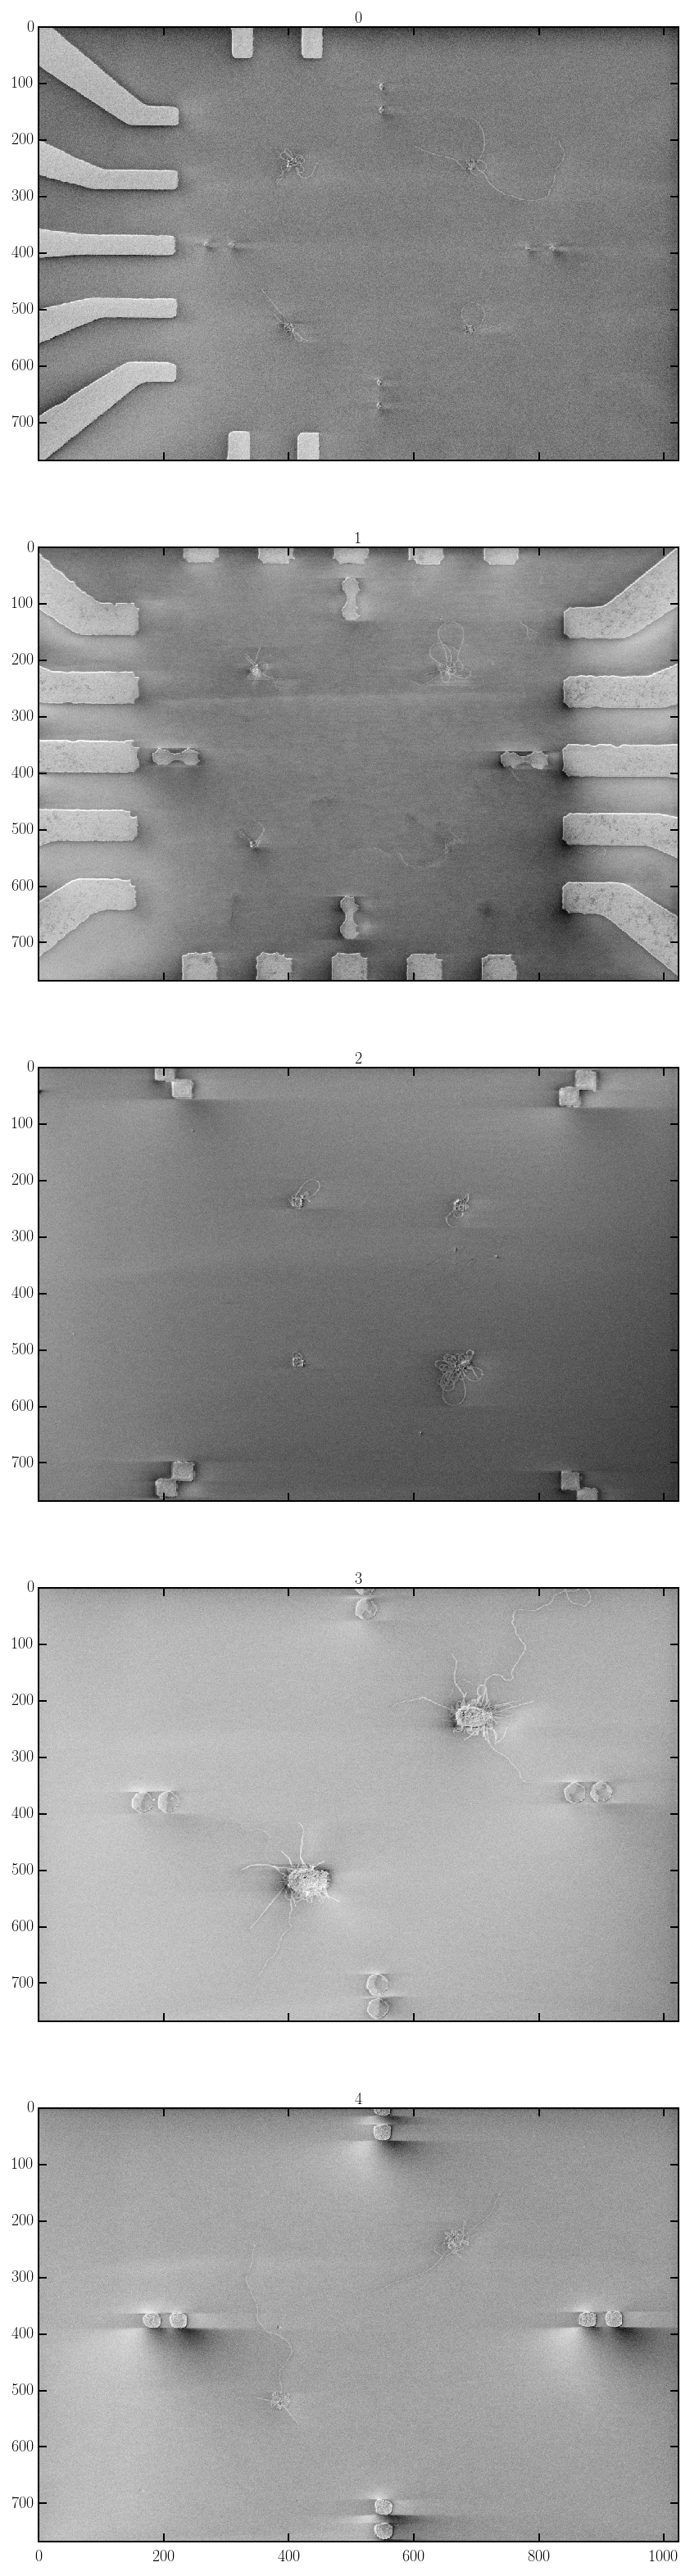

In [8]:
# Here are the unedited images
fig, axs = plt.subplots(5,1,sharex = True, sharey=False, 
                        figsize=(1*14,5*11))
axs = axs.flat

for i, im in enumerate(imarray):
    axs[i].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
    axs[i].set_title(i)

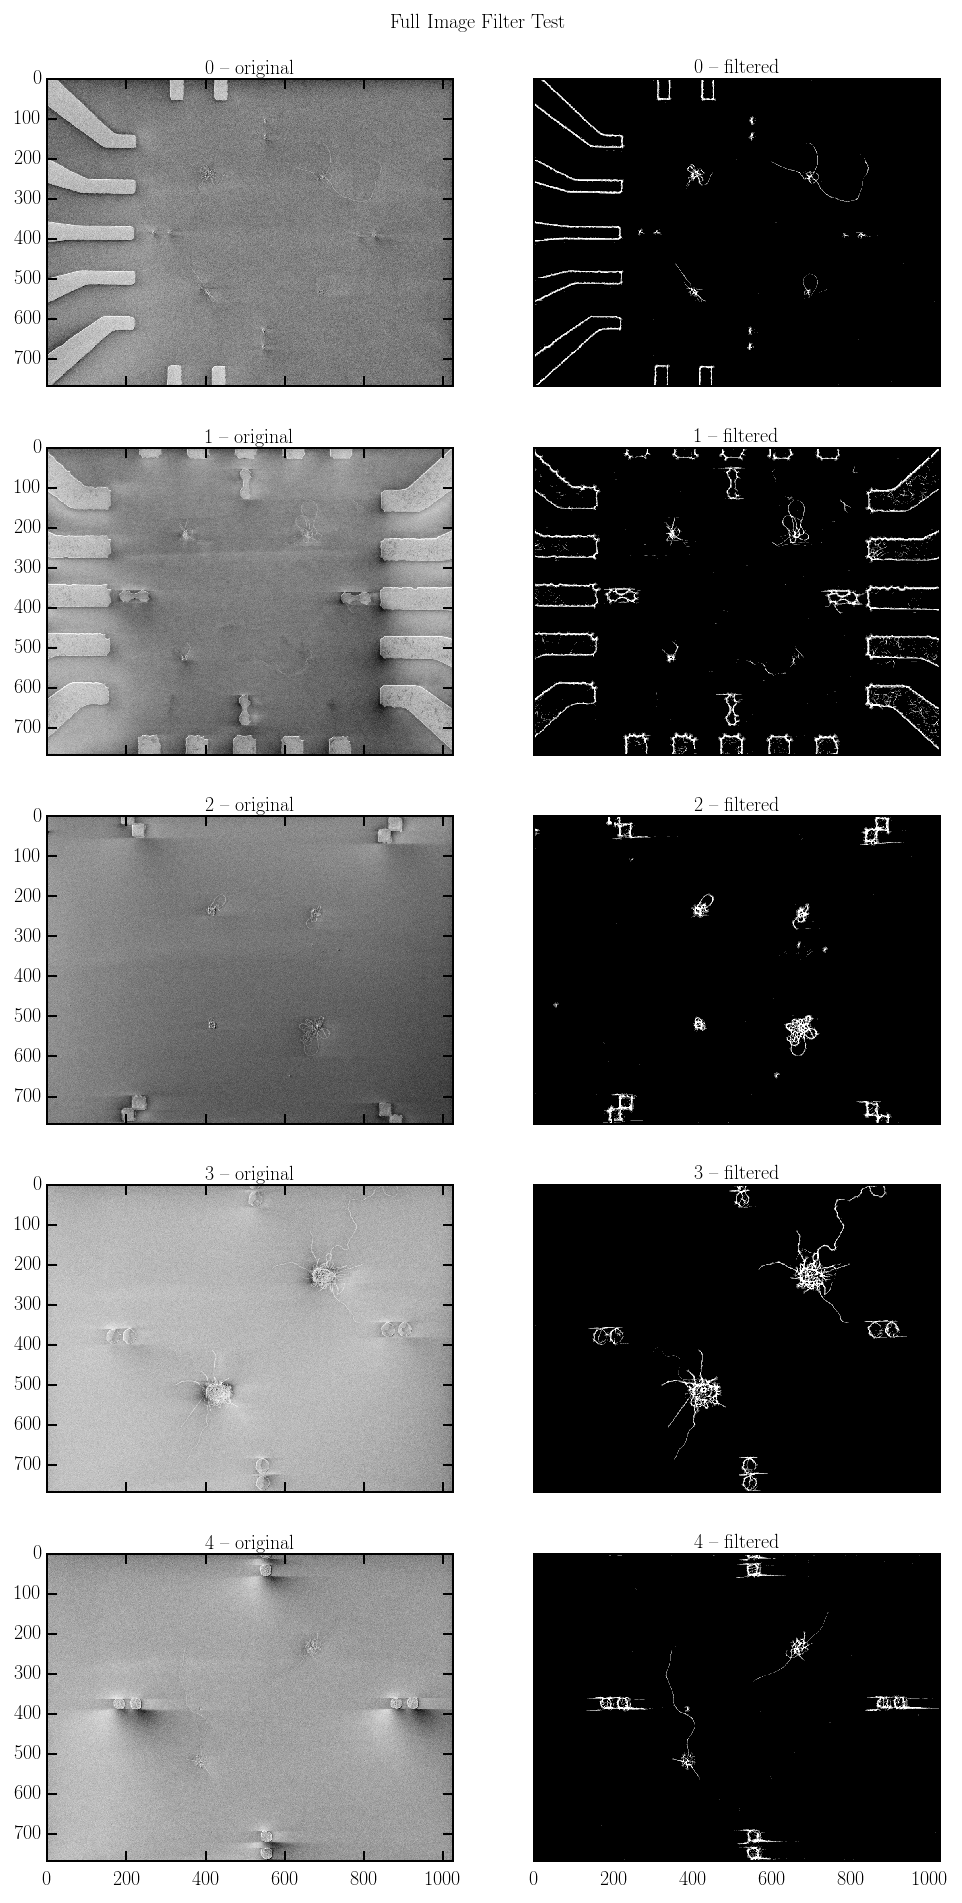

In [6]:
params = [1.75, 10.0, 16.0, 25, 15, 3.6] # k, a, L, N, R, threshold
mfilter = semimage.MatchedFilter(*params)

fig, axs = plt.subplots(5,2,sharex = True, sharey=True, 
                       figsize=(2*8,5*6))


imfiltered = np.zeros(imarray.shape)
for i, im in enumerate(imarray):
    for j in range(2):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{0} -- original'.format(i))
        else:
            imfiltered[i] = mfilter(im)
            axs[i, j].imshow(imfiltered[i], cmap = plt.cm.gray, vmin=0, vmax=5,
                             aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{0} -- filtered'.format(i))
            
fig.suptitle('Full Image Filter Test')
fig.subplots_adjust(top=0.95)

In [7]:
pickle.dump(imarray, open ( "unfiltered_test_set.p", "wb"))
pickle.dump(imfiltered, open( "filtered_test_set.p", "wb" ))

In [18]:
# load the filtered images
# rescale 0-255
# median filter with (3,3) matrix

images = pickle.load( open( "filtered_test_set.p", "rb" ) )
for i, im in enumerate(images):
    im *= (255.0/im.max())
    images[i] = ndimage.filters.median_filter(im, size=(3,3))

In [22]:
for i, im in enumerate(images):
    scipy.misc.toimage(im, cmin=0, cmax=50).save('filtered_test_image_{0}.png'.format(i))

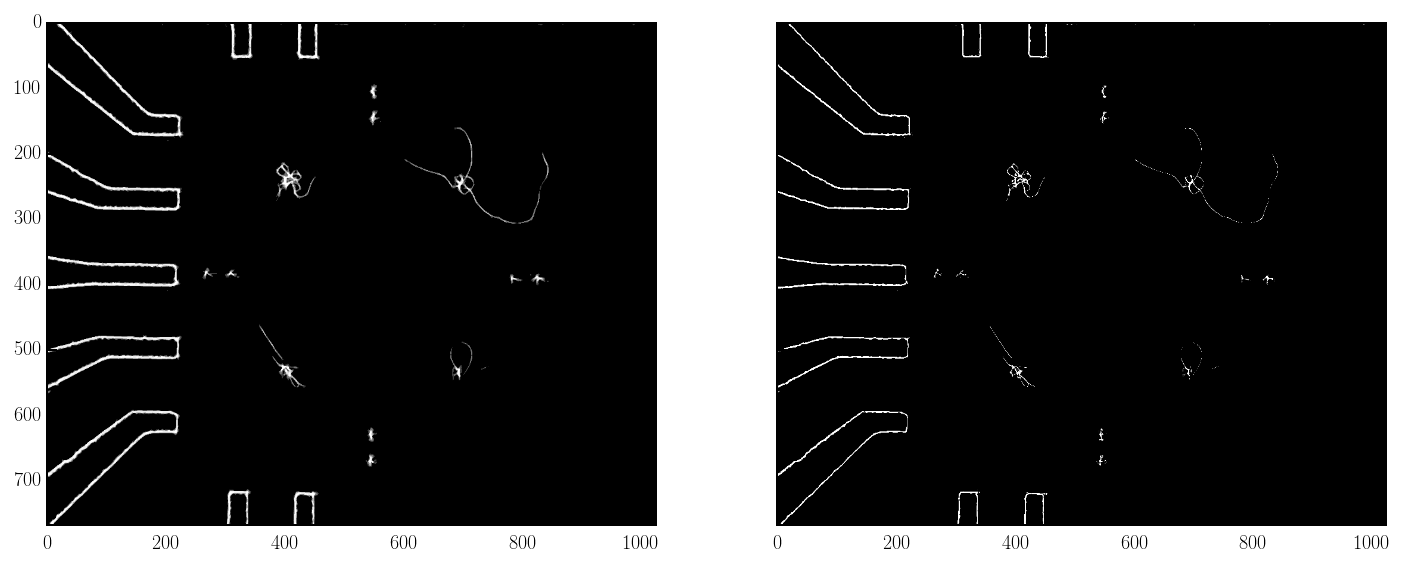

In [16]:
# check this cleaning technique that uses the gradient of the image to remove noise

ig = skimage.filters.sobel(images[0], mask=None)
im = images[0] - ig*255/(ig.max() - ig.min())

fig, axs = plt.subplots(1,2,sharex = True, sharey=True, 
                       figsize=(2*12,1*9))
axs[0].imshow(images[0], vmin=0, vmax=100, aspect = 'auto')
axs[1].imshow(im, vmin=0, vmax=20, aspect= 'auto')

That function seems to remove a lot of the signal I want to look at. I doubt it is a good idea.

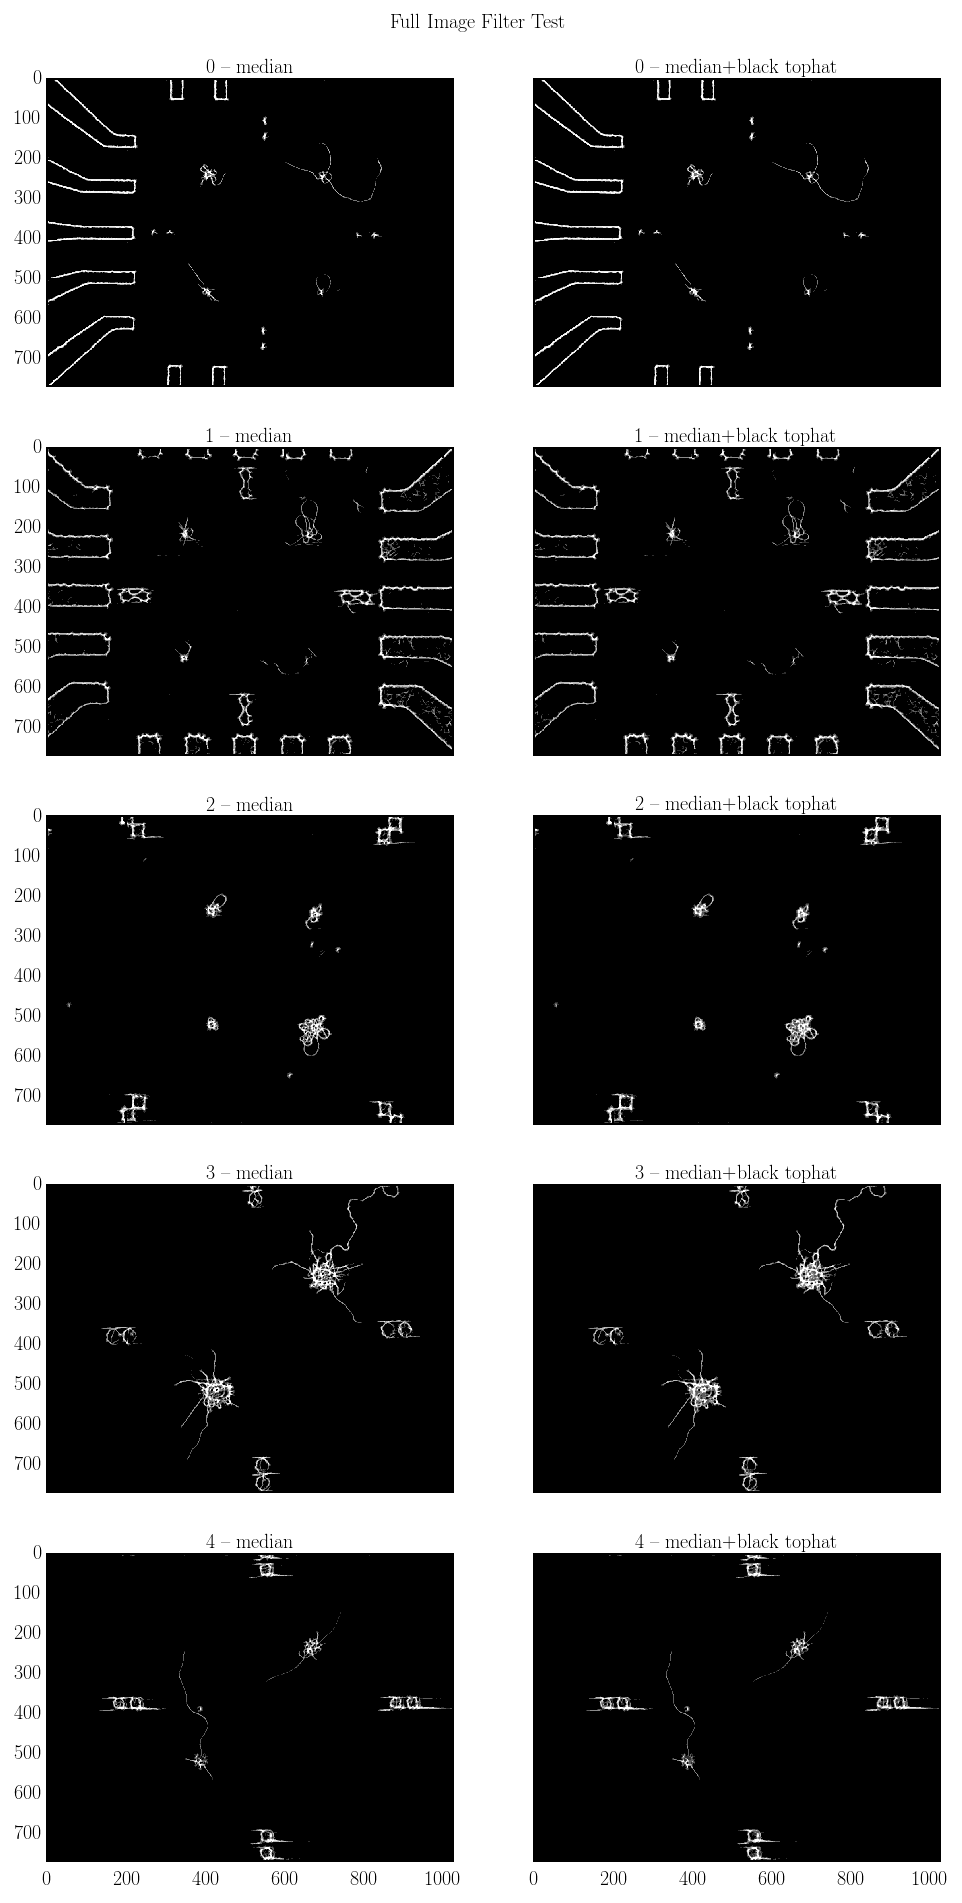

In [17]:
# black top hat filtering

from skimage.morphology import white_tophat, black_tophat, square

# returns bright spots where there are 
# dark holes smaller than the structuring element in the original image

s = square(3)

fig, axs = plt.subplots(5,2,sharex = True, sharey=True, 
                       figsize=(2*8,5*6))

for i, im in enumerate(images):
    for j in range(2):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, vmin = 0, vmax = 100, 
                            aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{0} -- median'.format(i))
        else:
            imfiltered[i] = mfilter(im)
            axs[i, j].imshow((black_tophat(im, s) + im), cmap = plt.cm.gray, vmin=0, vmax=100,
                             aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{0} -- median+black tophat'.format(i))
    images[i] = im
            
fig.suptitle('Full Image Filter Test')
fig.subplots_adjust(top=0.95)

I like the black tophat. The white tophat seems to remove too much information I want. Same problem I had with the gradient method.

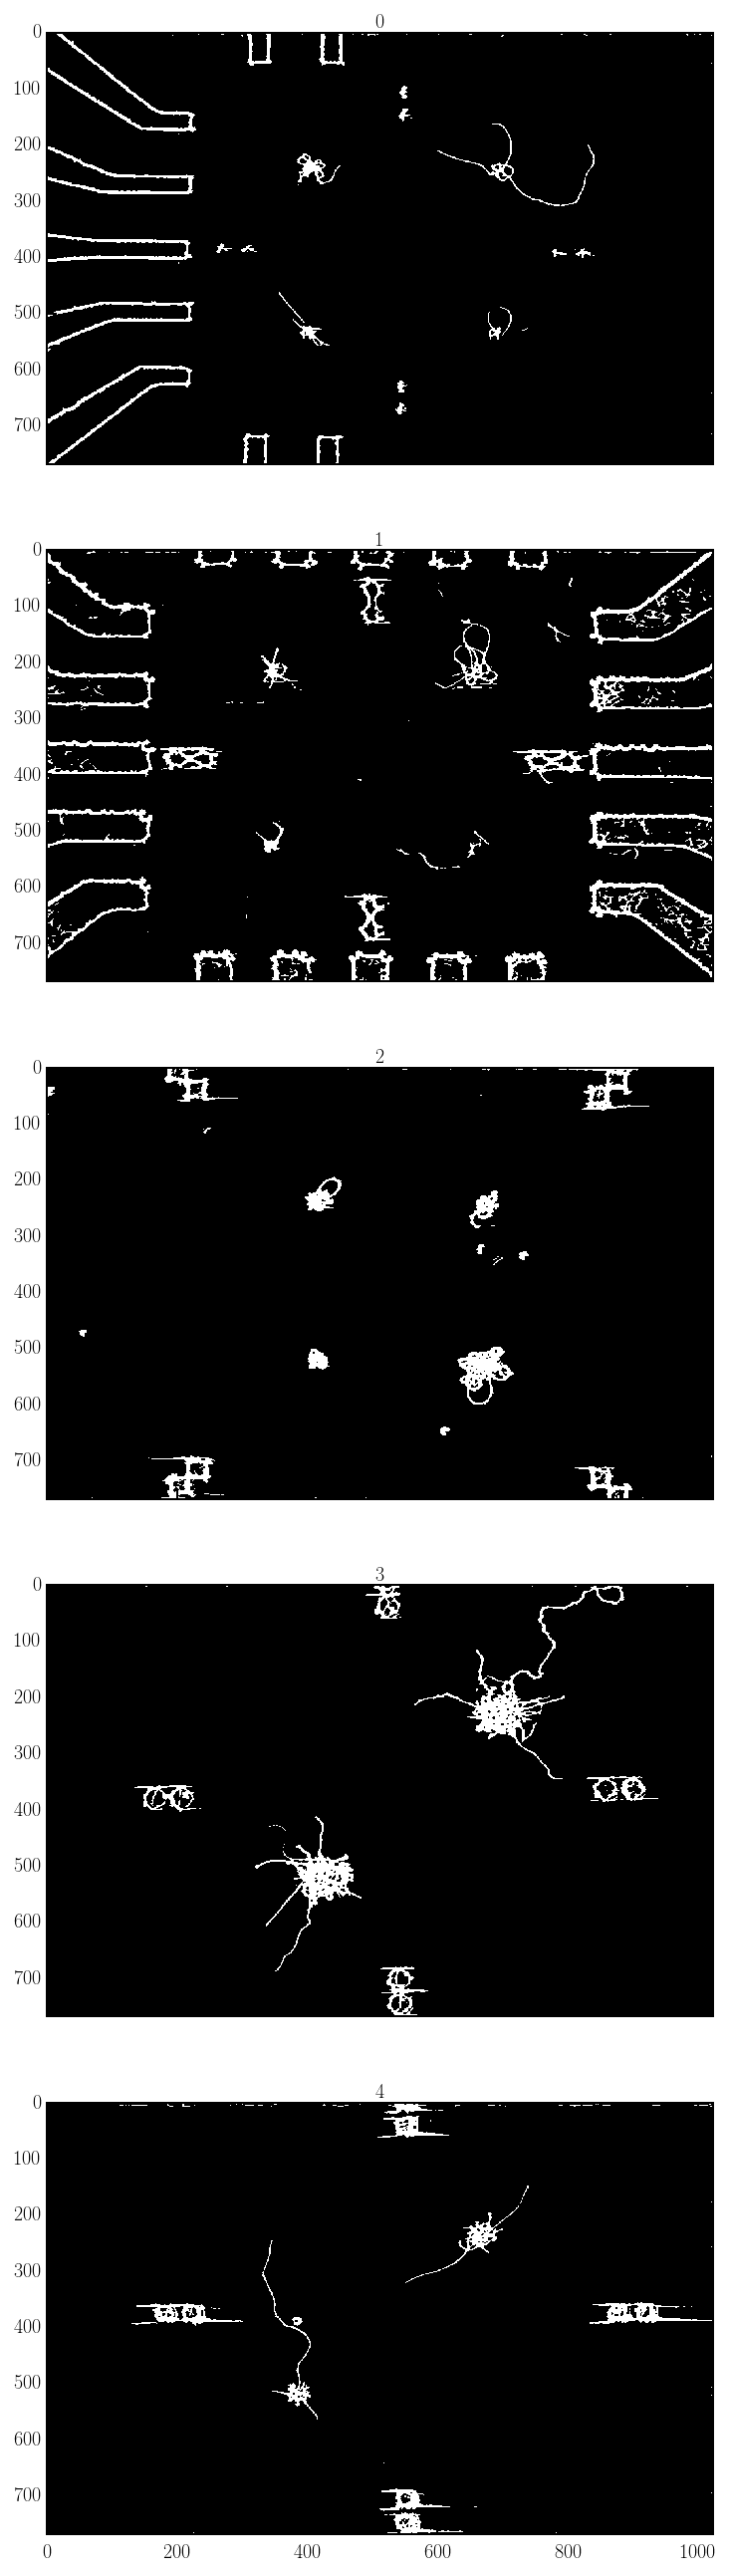

In [149]:
# now images has been loaded (matched filter bank results), median filtered (3,3), and black tophatted. cool.

# Here are the binary images
fig, axs = plt.subplots(5,1,sharex = True, sharey=False, 
                        figsize=(1*12,5*9))
axs = axs.flat

bimages = images>0
for i, im in enumerate(bimages):
    axs[i].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
    axs[i].set_title(i)

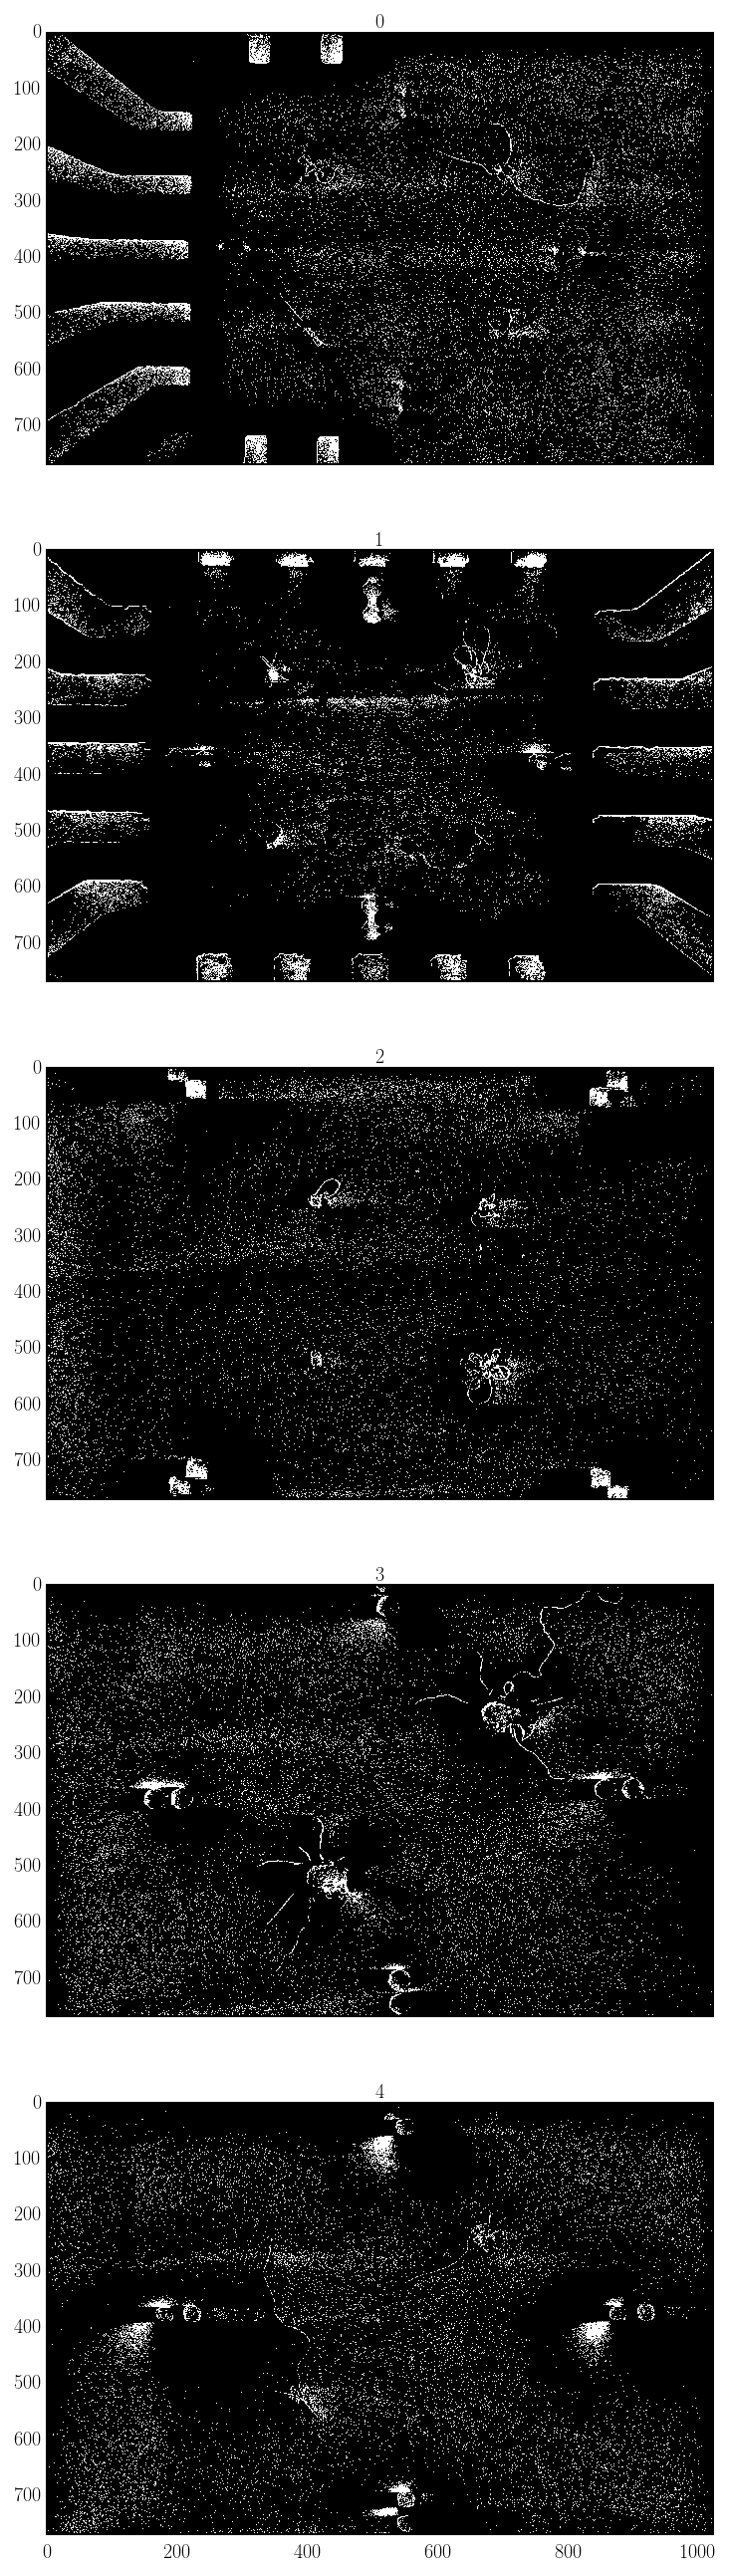

In [194]:
# let's see how this compares to just using a threshold for the original images

# single threshold methods...
# otsu -- lot's of remaining noise
# yen -- much worse than otsu
# li -- cut off pretty much everything
# isodata -- very similar to otsu

# local/adaptive methods....
# adaptive -- so much noise
# threshold -- probably the best result, still tons of noise
# percentile -- this is nice. still lots of noise

# none of these approach the matched filter bank results.

fig, axs = plt.subplots(5,1,sharex = True, sharey=False, 
                        figsize=(1*12,5*9))
axs = axs.flat

bimages = images>0
for i, im in enumerate(imarray):
    s = skimage.morphology.disk(100)
    bim = skimage.filters.rank.threshold_percentile(im, s, p0=.94)
    axs[i].imshow(bim, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
    axs[i].set_title(i)

In [275]:
def compare_images(im1, im2):
    fig, axs = plt.subplots(1,2,sharex = True, sharey=True, 
                       figsize=(2*10,1*7.5))
    axs[0].imshow(im1, vmin=0, vmax=None, aspect = 'auto')
    axs[1].imshow(im2, vmin=0, vmax=None, aspect = 'auto')
    axs[0].set_title('image 1')
    axs[1].set_title('image 2')

In [276]:
# reload the data for some testing

images = pickle.load( open( "filtered_test_set.p", "rb" ) )
for i, im in enumerate(images):
    im *= (255.0/im.max())
    images[i] = ndimage.filters.median_filter(im, size=(3,3))
    
bimages = images>0

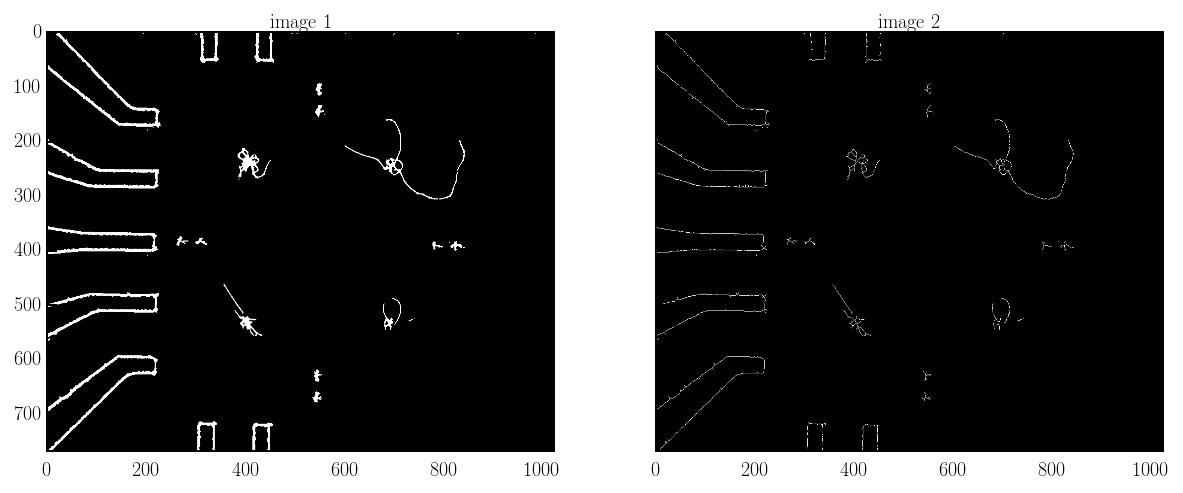

In [282]:
# skeletonizing does work pretty well at this point

im = bimages[0] # the result is pretty much the same using the grayscale or binary image
skel = skimage.morphology.medial_axis(im)
compare_images(im, skel)

In [283]:
# let's see if i can remove the tubes starting with the grayscale image

im = images[1]